<center>
<h1> Credit Risk Analytics
</center>

###### Definition of Target and Outcome Window:
One of the leading banks would like to predict bad customer while customer applying for loan. This model also called as PD Models (Probability of Default)


###### Data Pre-Processing - 
    - Missing Values Treatment - Numerical (Mean/Median imputation) and Categorical (Separate Missing Category or Merging)
    - Univariate Analysis - Outlier and Frequency Analysis
###### Data Exploratory Analysis
    - Bivariate Analysis - Numeric(TTest) and Categorical(Chisquare)
    - Bivariate Analysis - Visualization
    - Variable Transformation - P-Value based selection
    - Variable Transformation - Bucketing / Binning for numerical variables and Dummy for Categorical Variables
    - Variable Reduction - IV / Somers'D
    - Variable Reduction - Multicollinearity
###### Model Build and Model Diagnostics
    - Train and Test split
    - Significance of each Variable
    - Gini and ROC / Concordance analysis - Rank Ordering
    - Classification Table Analysis - Accuracy

###### Model Validation
    - OOS validation - p-value and sign testing for the model coefficients
    - Diagnostics check to remain similar to Training Model build
    - BootStrapping, if necessary
###### Model Interpretation for its properties
    - Inferencing for finding the most important contributors
    - Prediction of risk and proactive prevention by targeting segments of the population

#### import the packages

In [1]:
# import the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas_profiling   #need to install using anaconda prompt (pip install pandas_profiling)
import scipy.stats as stats

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

#### data import

In [4]:
# import the data under consideration
bankloans = pd.read_csv('D:/SampleData/bankloans.csv' )

#### UDFs

In [18]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.nunique(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'UNIQUE', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [6]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [7]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

#### data inspection

In [8]:
# check the metadata
bankloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
age         850 non-null int64
ed          850 non-null int64
employ      850 non-null int64
address     850 non-null int64
income      850 non-null int64
debtinc     850 non-null float64
creddebt    850 non-null float64
othdebt     850 non-null float64
default     700 non-null float64
dtypes: float64(4), int64(5)
memory usage: 59.8 KB


In [ ]:
bankloans.head(20)

In [ ]:
# profiling using pandas_profiling
# screen the variables and make a note of potential variables for model refinement
profile_report = pandas_profiling.ProfileReport(bankloans)
profile_report.to_file(output_file = 'profilereport.html')

In [9]:
bankloans.select_dtypes(['float64', 'int64']).columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

In [10]:
bankloans.loc[:, (bankloans.dtypes == 'float64') | (bankloans.dtypes == 'int64')].columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

In [12]:
# separate the categorical and continuous variable names
numeric_var_names = [key for key in dict(bankloans.dtypes) 
                     if dict(bankloans.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_names = [key for key in dict(bankloans.dtypes) if dict(bankloans.dtypes)[key] in ['object']]

In [13]:
# print the variable names in both the variables
print(numeric_var_names)
print(cat_var_names)

['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt', 'othdebt', 'default']
[]


In [19]:
# get the dataframe of only continuous variables
bankloans_num = bankloans[numeric_var_names]

In [20]:
# get the data audit report for all the variables
num_summary = bankloans_num.apply(continuous_var_summary)

In [22]:
num_summary

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
N,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,700.000000
NMISS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000
UNIQUE,37.000000,5.000000,33.000000,32.000000,129.000000,245.000000,842.000000,848.000000,2.000000
SUM,29775.000000,1454.000000,7281.000000,7116.000000,39674.000000,8645.900000,1340.284021,2616.970979,183.000000
MEAN,35.029412,1.710588,8.565882,8.371765,46.675294,10.171647,1.576805,3.078789,0.261429
MEDIAN,34.000000,1.000000,7.000000,7.000000,35.000000,8.700000,0.885091,2.003243,0.000000
STD,8.041432,0.927784,6.777884,6.895016,38.543054,6.719441,2.125840,3.398803,0.439727
VAR,64.664623,0.860783,45.939706,47.541251,1485.566998,45.150891,4.519196,11.551864,0.193360
MIN,20.000000,1.000000,0.000000,0.000000,13.000000,0.100000,0.011696,0.045584,0.000000
P1,21.000000,1.000000,0.000000,0.000000,14.490000,0.900000,0.030349,0.162394,0.000000


#### seperate out the data for existing and the new customers

In [ ]:
True == False

In [24]:
bankloans_existing = bankloans_num[bankloans_num.default.isnull() == 0]
bankloans_new = bankloans_num[bankloans_num.default.isnull() == 1]

#### data prepration/data cleaning

In [25]:
# Handling Outliers
bankloans_existing = bankloans_existing.apply(lambda x: x.clip(lower = x.dropna().quantile(0.01), upper = x.quantile(0.99)))

In [ ]:
# Handling missings
# bankloans_existing = bankloans_existing.apply(lambda x: missing_imputation(x))

#### bi variate analysis to identify corr 

In [27]:
# correlation matrix
corr_matrix = bankloans_existing.corr()
corr_matrix.to_excel('corr.xlsx')

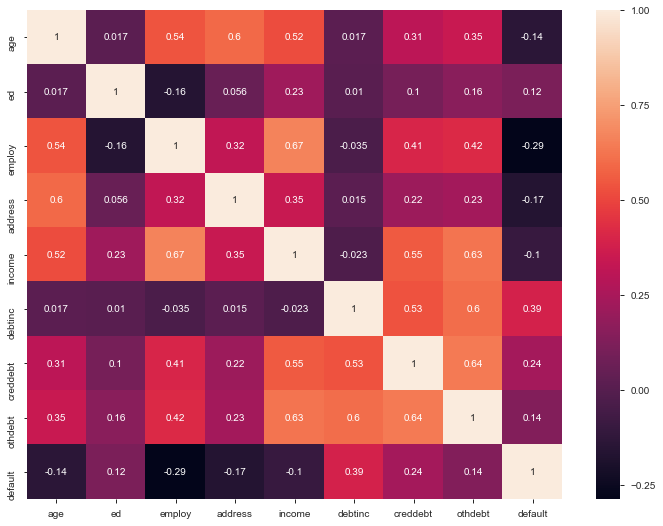

In [28]:
# visualize correlation matrix in Seaborn using a heatmap
plt.figure(figsize = (12, 9))
sns.heatmap(bankloans_existing.corr(), annot=True)

### Building logistic Regression Model

In [29]:
# import the package for logistic regression
import statsmodels.formula.api as smf

In [30]:
# Train and Test split
train, test = train_test_split(bankloans_existing, test_size = 0.3, 
                               random_state =  42)

In [46]:
# print the columns
' + '.join(train.columns)

'age + ed + employ + address + income + debtinc + creddebt + othdebt + default'

In [32]:
# execute a model for the X variables
m1 = smf.logit(formula = '''default ~ age + employ + address + debtinc + 
                                creddebt''', data = train).fit() 

Optimization terminated successfully.
         Current function value: 0.427051
         Iterations 7


In [47]:
# print the columns
'default ~ ' + ' + '.join(train.columns.difference(['default']))

'default ~ address + age + creddebt + debtinc + ed + employ + income + othdebt'

In [107]:
model_formula = '''default ~ address + creddebt + debtinc + employ + age'''

In [108]:
# execute a model for the X variables
m1 = smf.logit(formula = model_formula, data = train).fit() 

Optimization terminated successfully.
         Current function value: 0.427051
         Iterations 7


In [109]:
# print the model summary stats 
print(m1.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.272     
Dependent Variable: default          AIC:              430.5102  
Date:               2019-11-10 13:07 BIC:              455.6766  
No. Observations:   490              Log-Likelihood:   -209.26   
Df Model:           5                LL-Null:          -287.47   
Df Residuals:       484              LLR p-value:      5.6901e-32
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.7615    0.5836  -3.0185  0.0025  -2.9053  -0.6177
address       -0.0839    0.0254  -3.3047  0.0010  -0.1336  -0.0341
creddebt       0.5996    0.1035   5.7917  0.0000   0.3967   0.8025
debtinc        0.0710    0.021

### Building logistic Regression Model - using sklearn

In [ ]:
from sklearn.linear_model import LinearRegression

In [99]:
from sklearn.linear_model import LogisticRegression

In [101]:
X_vars = bankloans_existing[['age', 'employ', 'address', 'debtinc', 'creddebt']]
y = bankloans_existing.default

In [102]:
# Train and Test split
X_train, X_test, y_train, y_test = train_test_split(X_vars, y, test_size = 0.3, random_state =  42)

In [103]:
LogisticRegression?

In [104]:
m2 = LogisticRegression(solver = 'lbfgs').fit(X_train, y_train)

In [105]:
X_vars.columns

Index(['age', 'employ', 'address', 'debtinc', 'creddebt'], dtype='object')

In [106]:
m2.intercept_

array([-1.76420753])

In [110]:
m2.coef_

array([[ 0.03903061, -0.25248009, -0.08342646,  0.0715153 ,  0.59269708]])

In [ ]:
m2.score(X_train, y_train)

In [64]:
pd.DataFrame(['var', 'sd']).T

,0,1
0,var,sd


In [65]:
# empty dataframe
somersd_df = pd.DataFrame()

# iterate for each of the X - dependant variables and get the Somer's D value
for num_variable in bankloans_existing.columns.difference(['default']):
    
    # execute teh logit model
    logreg = smf.logit(str('default ~ ') + str(num_variable), bankloans_existing).fit()
    
    # get the predicted probabilities and create a dataframe with the predicted values
    y_score = logreg.predict(bankloans_existing)
    
    # name the column of the df as score
    y_score.columns = ['Score']
    
    # calculate the Somer's D values
    somers_d = 2 * metrics.roc_auc_score(bankloans_existing['default'], y_score) - 1
    
    # place the variable name and the Somers' D score in a temp dataframe
    temp = pd.DataFrame([num_variable, somers_d]).T
    temp.columns = ['Variable Name', 'SomersD']
    
    # append the data in the dataframe for all the X variables
    somersd_df = pd.concat([somersd_df, temp], axis = 0)

Optimization terminated successfully.
         Current function value: 0.559856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.569055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565619
         Iterations 5


In [66]:
# print the Somer's D values for all variables
# Bi-variate analysis to check the predictive power of each independent against dependent
somersd_df.sort_values(by = 'SomersD', ascending = False)

,Variable Name,SomersD
0,debtinc,0.470506
0,employ,0.409138
0,creddebt,0.272378
0,address,0.222384
0,age,0.206329
0,income,0.200273
0,othdebt,0.173806
0,ed,0.148302


#### VIF - Variance Inflation Factor

In [68]:
# get all the dependent avriables
features = ' + '.join(bankloans_existing.columns.difference(['default']))
features

'address + age + creddebt + debtinc + ed + employ + income + othdebt'

In [69]:
features = 'address + age + creddebt + debtinc + employ + income'

In [70]:
# run the dmatrices
a, b = dmatrices('default ~ ' + features, data = bankloans_existing, return_type = 'dataframe')

# get the VIF
vif = pd.DataFrame()
vif["features"] = b.columns
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif

,features,VIF Factor
0,Intercept,28.286222
1,address,1.559236
2,age,2.036933
3,creddebt,2.564921
4,debtinc,1.778339
5,employ,1.997947
6,income,2.601717


### predict the values

In [71]:
# predict the values on training and testing
train_predict = m1.predict(train)
test_predict = m1.predict(test)

- p (Default = 1) = exp(LE) / (1 + exp(LE)) 

#### check model accuracy

In [73]:
# model accuracy | Method 1: AUC
train_auc = metrics.roc_auc_score(train['default'], train_predict)
test_auc = metrics.roc_auc_score(test['default'], test_predict)

print("The AUC for the model built on the Train Data is : ", train_auc)
print("The AUC for the model built on the Test Data is : ", test_auc)

The AUC for the model built on the Train Data is :  0.8368690256582257
The AUC for the model built on the Test Data is :  0.8859170997591583


#### combine the actual Y values with predicted probabilities

In [74]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
train_predicted_prob = pd.DataFrame(train_predict)
train_predicted_prob.columns = ['prob']

# making a DataFrame with actual and prob columns
train_pf = pd.concat([train['default'], train_predicted_prob], axis = 1)
train_pf.columns = ['actual', 'prob']

In [75]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
test_predicted_prob = pd.DataFrame(test_predict)
test_predicted_prob.columns = ['prob']

# making a DataFrame with actual and prob columns
test_pf = pd.concat([test['default'], test_predicted_prob], axis=1)
test_pf.columns = ['actual','prob']

#### get the predicted Y at cutoff = 0.3

In [76]:
train_pf['predicted'] = train_pf.prob.apply(lambda x: 0.0 if x < 0.3 else 1.0)

#### calculate the confusion matrix parameters

In [ ]:
train_pf.head()

In [77]:
train_pf['tp'] = train_pf.apply(lambda x: 1.0 if x['actual'] == 1 and x['predicted'] == 1 else 0.0, axis = 1)
train_pf['fp'] = train_pf.apply(lambda x: 1.0 if x['actual'] == 0 and x['predicted'] == 1 else 0.0, axis = 1)
train_pf['tn'] = train_pf.apply(lambda x: 1.0 if x['actual'] == 0 and x['predicted'] == 0 else 0.0, axis = 1)
train_pf['fn'] = train_pf.apply(lambda x: 1.0 if x['actual'] == 1 and x['predicted'] == 0 else 0.0, axis = 1)

In [78]:
# calculate accuracy 
accuracy = (train_pf.tp.sum() + train_pf.tn.sum()) / (train_pf.tp.sum() + 
                            train_pf.tn.sum() + train_pf.fp.sum() + train_pf.fn.sum())
accuracy

0.7591836734693878

In [79]:
# calculate sensitivity 
sensitivity = (train_pf.tp.sum()) / (train_pf.tp.sum() + train_pf.fn.sum())
sensitivity

0.7388059701492538

In [81]:
np.arange(0, 1, 0.01)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

In [80]:
np.linspace(0,1,100)

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [82]:
## Intuition behind ROC curve - confusion matrix for each different cut-off shows trade off in sensitivity and specificity
roc_like_df = pd.DataFrame()
train_temp = train_pf.copy()

for cut_off in np.linspace(0,1,100):
    train_temp['cut_off'] = cut_off
    train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
    train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
    train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
    sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
    specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
    accuracy = (train_temp['tp'].sum()  + train_temp['tn'].sum() ) / (train_temp['tp'].sum() + train_temp['fn'].sum() + train_temp['tn'].sum() + train_temp['fp'].sum())
    
    roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity, accuracy]).T
    roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity', 'accuracy']
    roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)


In [86]:
roc_like_df.head()

,cutoff,sensitivity,specificity,accuracy,total
0,0.000000,1.000000,0.000000,0.273469,1.000000
0,0.010101,1.000000,0.103933,0.348980,1.103933
0,0.020202,1.000000,0.162921,0.391837,1.162921
0,0.030303,1.000000,0.205056,0.422449,1.205056
0,0.040404,0.992537,0.255618,0.457143,1.248155


#### finding ideal cut-off
    - Choosen Best Cut-off is 0.343434	 based on highest (sensitivity+specicity)

In [84]:
# sum the sensitivity and specificity
roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']

In [87]:
# cut-off based on highest sum(sensitivity + specicity) - common way of identifying cut-off
roc_like_df[roc_like_df['total'] == roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,accuracy,total
0,0.232323,0.850746,0.685393,0.730612,1.53614


In [88]:
# cut-off based on highest accuracy - some teams use this as methodology to decide the cut-off
roc_like_df[roc_like_df['accuracy'] == roc_like_df['accuracy'].max()]

,cutoff,sensitivity,specificity,accuracy,total
0,0.494949,0.485075,0.918539,0.8,1.403614


#### do the final predictions at the 0.2323 as cutoff

In [89]:
test_pf['predicted'] = test_pf['prob'].apply(lambda x: 1 if x > 0.2323 else 0)
train_pf['predicted'] = train_pf['prob'].apply(lambda x: 1 if x > 0.2323 else 0)

In [91]:
# confusion matrix - Method 1 (training dataset)
pd.crosstab(train_pf['actual'], train_pf['predicted'])

predicted,0,1
actual,,
0.0,244,112
1.0,20,114


In [92]:
# confusion matrix - Method 2 (training dataset)
metrics.confusion_matrix(train_pf['actual'], train_pf['predicted'])

array([[244, 112],
       [ 20, 114]], dtype=int64)

In [93]:
# confusion matrix of testing dataset
pd.crosstab(test_pf['actual'], test_pf['predicted'])

predicted,0,1
actual,,
0.0,117,44
1.0,9,40


In [94]:
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_pf.actual, train_pf.predicted))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_pf.actual, test_pf.predicted))

The overall accuracy score for the Train Data is :  0.7306122448979592
The overall accuracy score for the Test Data  is :  0.7476190476190476


### Decile Analysis

In [ ]:
#Decile analysis
#Top-two deciles - High risk customers - will reject applications
#3rd,4th, 5th deciesl - medium risk customers - will accept application with proper scrutiny
#6th decile onwards - low risk customers - accept the application

In [ ]:
#Decile analysis for validation of models - Business validation
train_pf['Deciles'] = pd.qcut(train_pf['prob'], 10, labels = False)
test_pf['Deciles'] = pd.qcut(test_pf['prob'], 10, labels = False)

#### Decile Analysis for train data

In [ ]:
no_1s = train_pf[['Deciles','actual']].groupby(train_pf.Deciles).sum().sort_index(ascending=False)['actual']
no_total = train_pf[['Deciles','actual']].groupby(train_pf.Deciles).count().sort_index(ascending=False)['actual']
max_prob = train_pf[['Deciles','prob']].groupby(train_pf.Deciles).max().sort_index(ascending=False)['prob']
min_prob = train_pf[['Deciles','prob']].groupby(train_pf.Deciles).min().sort_index(ascending=False)['prob']

In [ ]:
Decile_analysis_train = pd.concat([ min_prob, max_prob, no_1s, no_total-no_1s, no_total], axis=1)

In [ ]:
Decile_analysis_train.columns = ['Min_prob', 'Max_prob', '#1', '#0', 'Total']

In [ ]:
Decile_analysis_train.to_csv('Decile_analysis_train.csv')
Decile_analysis_train

#### Decile Analysis for test data

In [ ]:
no_1s = test_pf[['Deciles','actual']].groupby(test_pf.Deciles).sum().sort_index(ascending=False)['actual']
no_total = test_pf[['Deciles','actual']].groupby(test_pf.Deciles).count().sort_index(ascending=False)['actual']
max_prob = test_pf[['Deciles','prob']].groupby(test_pf.Deciles).max().sort_index(ascending=False)['prob']
min_prob = test_pf[['Deciles','prob']].groupby(test_pf.Deciles).min().sort_index(ascending=False)['prob']

In [ ]:
Decile_analysis_test = pd.concat([min_prob, max_prob, no_1s, no_total-no_1s, no_total], axis=1)

In [ ]:
Decile_analysis_test.columns = ['Min_prob', 'Max_prob', '#1', '#0', 'Total']

In [ ]:
Decile_analysis_test.to_csv('Decile_analysis_test.csv')
Decile_analysis_test

## Predicting new customers (Implementation of Model on new data)

In [ ]:
# predciting new customers good or bad
bankloans_new.head()

#### before scoring new customers, you need to process the data using the sames steps you followed while building the model

In [95]:
bankloans_new['prob'] = m1.predict(bankloans_new)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [97]:
bankloans_new['default'] = bankloans_new['prob'].apply(lambda x: 1 if x > 0.2323 else 0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [98]:
bankloans_new.default.value_counts()

0    86
1    64
Name: default, dtype: int64

#### We are rejecting applications for 43 customers based on cut-off = 0.343434